Total Classes Detected: 10
Importing Classes .......
0 1 2 3 4 5 6 7 8 9  
Total Images in Images List =  10160
Total IDS in classNo List=  10160
(10160, 32, 32, 3)
(6502, 32, 32, 3)
(2032, 32, 32, 3)
(1626, 32, 32, 3)
[641, 684, 634, 647, 660, 647, 651, 650, 640, 648]


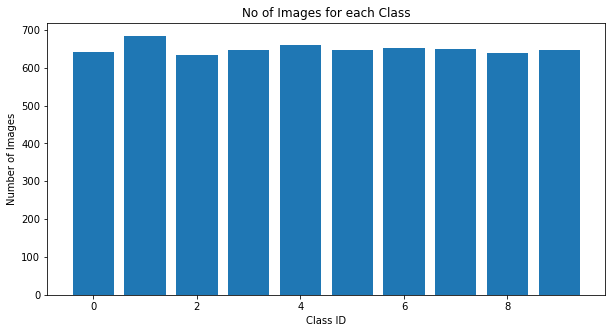

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 30)         

In [ ]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout,Flatten
from keras.layers.convolutional import Conv2D,MaxPooling2D
import pickle
 
################ PARAMETERS ########################
path = 'myData'
testRatio = 0.2
valRatio = 0.2
imageDimensions= (32,32,3)
batchSizeVal= 50
epochsVal = 10
stepsPerEpochVal = 2000
####################################################
 
#### IMPORTING DATA/IMAGES FROM FOLDERS
count = 0
images = []     # LIST CONTAINING ALL THE IMAGES
classNo = []    # LIST CONTAINING ALL THE CORRESPONDING CLASS ID OF IMAGES
myList = os.listdir(path)
print("Total Classes Detected:",len(myList))
noOfClasses = len(myList)
print("Importing Classes .......")
for x in range (0,noOfClasses):
    myPicList = os.listdir(path+"/"+str(x))
    for y in myPicList:
        curImg = cv2.imread(path+"/"+str(x)+"/"+y)
        curImg = cv2.resize(curImg,(32,32))
        images.append(curImg)
        classNo.append(x)
    print(x,end= " ")
print(" ")
print("Total Images in Images List = ",len(images))
print("Total IDS in classNo List= ",len(classNo))
 
#### CONVERT TO NUMPY ARRAY
images = np.array(images)
classNo = np.array(classNo)
print(images.shape)
 
#### SPLITTING THE DATA
X_train,X_test,y_train,y_test = train_test_split(images,classNo,test_size=testRatio)
X_train,X_validation,y_train,y_validation = train_test_split(X_train,y_train,test_size=valRatio)
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)
 
#### PLOT BAR CHART FOR DISTRIBUTION OF IMAGES
numOfSamples= []
for x in range(0,noOfClasses):
    #print(len(np.where(y_train==x)[0]))
    numOfSamples.append(len(np.where(y_train==x)[0]))
print(numOfSamples)
 
plt.figure(figsize=(10,5))
plt.bar(range(0,noOfClasses),numOfSamples)
plt.title("No of Images for each Class")
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.show()
 
#### PREPOSSESSING FUNCTION FOR IMAGES FOR TRAINING
def preProcessing(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img/255
    return img
# img = preProcessing(X_train[30])
# img = cv2.resize(img,(300,300))
# cv2.imshow("PreProcesssed",img)
# cv2.waitKey(0)
 
X_train= np.array(list(map(preProcessing,X_train)))
X_test= np.array(list(map(preProcessing,X_test)))
X_validation= np.array(list(map(preProcessing,X_validation)))
 
 
#### RESHAPE IMAGES
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
X_validation = X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)
 
#### IMAGE AUGMENTATION
dataGen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)
dataGen.fit(X_train)
 
#### ONE HOT ENCODING OF MATRICES
y_train = to_categorical(y_train,noOfClasses)
y_test = to_categorical(y_test,noOfClasses)
y_validation = to_categorical(y_validation,noOfClasses)
 
#### CREATING THE MODEL
def myModel():
    noOfFilters = 60
    sizeOfFilter1 = (5,5)
    sizeOfFilter2 = (3, 3)
    sizeOfPool = (2,2)
    noOfNodes= 500
 
    model = Sequential()
    model.add((Conv2D(noOfFilters,sizeOfFilter1,input_shape=(imageDimensions[0],
                      imageDimensions[1],1),activation='relu')))
    model.add((Conv2D(noOfFilters, sizeOfFilter1, activation='relu')))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add((Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu')))
    model.add((Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add(Dropout(0.5))
 
    model.add(Flatten())
    model.add(Dense(noOfNodes,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses, activation='softmax'))
 
    model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model
 
model = myModel()
print(model.summary())
 
#### STARTING THE TRAINING PROCESS
history = model.fit_generator(dataGen.flow(X_train,y_train,
                                 batch_size=batchSizeVal),
                                 steps_per_epoch=stepsPerEpochVal,
                                 epochs=epochsVal,
                                 validation_data=(X_validation,y_validation),
                                 shuffle=1)
 
#### PLOT THE RESULTS 
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()
 
#### EVALUATE USING TEST IMAGES
score = model.evaluate(X_test,y_test,verbose=0)
print('Test Score = ',score[0])
print('Test Accuracy =', score[1])
 
#### SAVE THE TRAINED MODEL
pickle_out= open("model_trained.p", "wb")
pickle.dump(model,pickle_out)
pickle_out.close()